# Finding routes for appliance delivery with Vehicle Routing Problem Solver


<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finding-routes-for-appliance-delivery-with-Vehicle-Routing-Problem-Solver" data-toc-modified-id="Finding-routes-for-appliance-delivery-with-Vehicle-Routing-Problem-Solver-1">Finding routes for appliance delivery with Vehicle Routing Problem Solver</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-orders-layer-with-csv-file:" data-toc-modified-id="Create-orders-layer-with-csv-file:-1.0.1">Create orders layer with csv file:</a></span></li><li><span><a href="#Create-routes-layer-with-csv-file:" data-toc-modified-id="Create-routes-layer-with-csv-file:-1.0.2">Create routes layer with csv file:</a></span></li><li><span><a href="#Create-depots-layer-with-csv-file:" data-toc-modified-id="Create-depots-layer-with-csv-file:-1.0.3">Create depots layer with csv file:</a></span></li><li><span><a href="#Draw-the-depots-and-orders-in-map." data-toc-modified-id="Draw-the-depots-and-orders-in-map.-1.0.4">Draw the <code>depots</code> and <code>orders</code> in map.</a></span></li><li><span><a href="#Create-depots-layer-by-geocoding-the-location" data-toc-modified-id="Create-depots-layer-by-geocoding-the-location-1.0.5">Create depots layer by geocoding the location</a></span></li><li><span><a href="#Create-routes-layer-with-JSON-file" data-toc-modified-id="Create-routes-layer-with-JSON-file-1.0.6">Create routes layer with JSON file</a></span></li></ul></li><li><span><a href="#Solve-VRP" data-toc-modified-id="Solve-VRP-1.1">Solve VRP</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-1.2">Result</a></span></li></ul></li></ul></div>

The network module of the ArcGIS API for Python can be used to solve different types of network analysis operations. For example, an appliance delivery company wants to serve multiple customers in a day using several delivery drivers, a health inspection company needs to schedule inspection visits for the inspectors. The problem that is common to these examples is called vehicle routing problem (VRP). Each such problem requires to determine which orders should be serviced by which vehicle/driver and in what sequence, so the total operating cost is minimized and the routes are operational. In addition, the VRP solver can solve more specific problems because numerous options are available, such as matching vehicle capacities with order quantities, giving breaks to drivers, and pairing orders so they are serviced by the same route.

In this sample, we find a solution for an appliance delivery company to find routes for two vehicles which start from the warehouse and return to the same, at the end of the working day. We will find optimized routes given a set of orders to serve and a set of vehicles with constraints. All we need to do is pass in the `depot` locations, `route` (vehicle/driver) details, the `order` locations, and specify additional properties for `orders`.  The VRP service will return `routes` with directions. Once you have the results, you can add the `routes` to a map, display the turn-by-turn directions, or integrate them further into your application. To learn more about the capabilities of the routing and directions services, please visit the [documentation](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/vehicle-routing-problem.htm#).

**Note** :If you run the tutorial using ArcGIS Online, 2 [credits](http://pro.arcgis.com/en/pro-app/tool-reference/appendices/geoprocessing-tools-that-use-credits.htm#ESRI_SECTION2_5FAF16DB9F044F78AF164A22752A9A7F) will be consumed.

As a first step, let's import required libraries and establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. If you dont have an ArcGIS account, [get ArcGIS Trial](https://www.esri.com/en-us/arcgis/trial).

In [1]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
import datetime
import getpass
from IPython.display import HTML

from arcgis import geocoding
from arcgis.features import Feature, FeatureSet
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [2]:
portal_url = 'https://www.arcgis.com'
#connect to your GIS
user_name = 'arcgis_python' # '<user_name>'
password = 'P@ssword123' #'<password>'
my_gis = GIS(portal_url, user_name, password)

To solve the Vehicle Routing Problem, we need `orders` layer with stop information, `depots` layer with the warehouse location information from where the routes start and `routes` table with constraints on routes like maximum total time the driver can work etc.
To provide this information to the service, different types of inputs are supported as listed below:

- Csv file
- Address information to geocode or reverse geocode
- Json file with attribute names and values

Let us see how to get the layer from each of these input types.

### Create orders layer with csv file:
Use this parameter to specify the orders the routes should visit. An order can represent a delivery (for example, furniture delivery), a pickup (such as an airport shuttle bus picking up a passenger), or some type of service or inspection (a tree trimming job or building inspection, for instance). When specifying the orders, you can specify additional properties for orders using attributes, such as their names, service times, time windows, pickup or delivery quantities etc.

Orders csv file has an `Address` column. So, we convert orders csv to a SpatialDataFrame using the address values to geocode order locations.To perform the geocode operations, we imported the geocoding module of the ArcGIS API.

In [32]:
orders_csv = "data/orders.csv"

# Read the csv file and convert the data to feature set
orders_df = pd.read_csv(orders_csv)
orders_sdf = pd.DataFrame.spatial.from_df(orders_df, "Address")
orders_fset = orders_sdf.spatial.to_featureset()

In [33]:
orders_sdf.head(3)

,Address,SHAPE
0,"602 Murray Cir, Sausalito, CA 94965","{""x"": -122.47768037299994, ""y"": 37.83653954200..."
1,"340 Stockton St, San Francisco, CA 94108","{""x"": -122.40684618399996, ""y"": 37.78912147200..."
2,"3619 Balboa St, San Francisco, CA 94121","{""x"": -122.49772171699999, ""y"": 37.77567151400..."


### Create routes layer with csv file:

A route specifies vehicle and driver characteristics. A route can have start and end depot service times, a fixed or flexible starting time, time-based operating costs, distance-based operating costs, multiple capacities, various constraints on a driver’s workday, and so on. When specifying the routes, you can set properties for each one by using attributes. Attributes in the csv are explained below.

`Name`- The name of the route

`StartDepotName`- The name of the starting depot for the route. This field is a foreign key to the Name field in Depots.

`EndDepotName`-  The name of the ending depot for the route. This field is a foreign key to the Name field in the Depots class.

`EarliestStartTime`- The earliest allowable starting time for the route. 

`LatestStartTime`- The latest allowable starting time for the route.

`Capacities`- The maximum capacity of the vehicle.

`CostPerUnitTime`- The monetary cost incurred per unit of work time, for the total route duration, including travel times as well as service times and wait times at orders, depots, and breaks.

`MaxOrderCount`- The maximum allowable number of orders on the route.

`MaxTotalTime`- The maximum allowable route duration.

`AssignmentRule`- This field specifies the rule for assigning the order to a route for example, Exclude, Preserve route, Preserve rooute with relative sequence, override etc, please read [documentation](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.analysis.html#solve-vehicle-routing-problem) for more details. 

To get a featureset from dataframe, we convert the CSV to a pandas data frame using read_csv function. Note that in our CSV, `EarliestStartTime` and `LatestStartTime` values are represented as strings denoting time in the local time zone of the computer. So we need to parse these values as date-time values which we accomplish by specifying to_datetime function as the datetime parser.

When calling `arcgis.network.analysis.solve_vehicle_routing_problem` function we need to pass the datetime values in milliseconds since epoch. The `routes_df` dataframe stores these values as datetime type. We convert from datetime to int64 datatype which stores the values in nano seconds. We then convert those to milliseconds.


In [34]:
routes_csv = "data/routes.csv"

# Read the csv file
routes_df = pd.read_csv(routes_csv, parse_dates=["EarliestStartTime", "LatestStartTime"], date_parser=pd.to_datetime)
routes_df["EarliestStartTime"] = routes_df["EarliestStartTime"].astype("int64") / 10 ** 6
routes_df["LatestStartTime"] = routes_df["LatestStartTime"].astype("int64") / 10 ** 6
routes_fset = arcgis.features.FeatureSet.from_dataframe(routes_df)

In [35]:
routes_df

,ObjectID,Name,StartDepotName,EndDepotName,EarliestStartTime,LatestStartTime,Capacities,CostPerUnitTime,MaxOrderCount,MaxTotalTime,AssignmentRule
0,1,Route1,Warehouse,Warehouse,-2.209133e+12,-2.209126e+12,6,20,6,150,1
1,2,Route2,Warehouse,Warehouse,-2.209133e+12,-2.209126e+12,6,20,6,150,1


### Create depots layer with csv file:
Use this parameter to specify a location that a vehicle departs from at the beginning of its workday and returns to, at the end of the workday. Vehicles are loaded (for deliveries) or unloaded (for pickups) at depots at the start of the route.

Depots CSV file has depot locations in columns called `Latitude` (representing Y values) and `Longitude` (representing X values). So, we convert depots CSV to a SpatialDataFrame using the X and Y values. We need to reverse geocode these locations as these are provided in latitude/longitude format. Depots must have `Name` values because the `StartDepotName` and `EndDepotName` attributes of the `routes` parameter reference the names you specify here. 

In [36]:
depots_csv = "data/depots.csv"

# Read the csv file and convert the data to feature set
depots_df = pd.read_csv(depots_csv)
depots_sdf = pd.DataFrame.spatial.from_xy(depots_df, "Longitude", "Latitude")
depots_sdf = depots_sdf.drop(axis=1, labels=["Longitude", "Latitude"])
depots_fset = depots_sdf.spatial.to_featureset()
depots_sdf

,Name,SHAPE
0,Warehouse,"{""x"": -122.39383000000001, ""y"": 37.797505, ""sp..."



### Draw the `depots` and `orders` in map.
To visualize the `orders` and `depots` layer in the map, create a map as done below. The layer can also be drawn with suitable symbol, size and color with draw service in map. The green dots represent stops location to service and the orange square represents the depot from where `routes` should start.


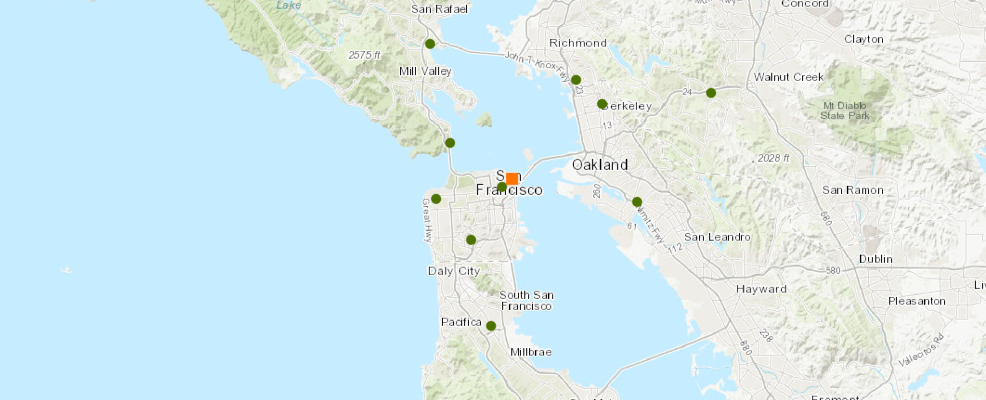

In [42]:
# Create a map instance to visualize inputs in map
map_view_inputs = my_gis.map('San Fransisco, United States', zoomlevel=10)
map_view_inputs

In [38]:
# Visualize order and depot locations with symbology
map_view_inputs.draw(orders_fset, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})
map_view_inputs.draw(depots_fset, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})

Alternatively, if the input data is provided in different formats, we could still create layers from those data. In practice, there might not always be csv files for all the inputs. It could be just a list of addresses or the inputs are feed from an automated script or server output in JSON format from REST API.

Let's see how to convert each of input type to featureset to provide as input directly to the VRP service.

### Create depots layer by geocoding the location

If we know address of depot, we would geocode the address to get the feature set to input that to the VRP solver as follows.

In [39]:
depot_geocoded_fs = geocoding.geocode("2-98 Pier 1, San Francisco, California, 94111", 
                                      as_featureset=True, max_locations=1)
depot_geocoded_fs.sdf


,AddBldg,AddNum,AddNumFrom,AddNumTo,AddRange,Addr_type,BldgName,BldgType,Block,City,Country,DisplayX,DisplayY,Distance,District,ExInfo,LangCode,LevelName,LevelType,Loc_name,LongLabel,Match_addr,MetroArea,Nbrhd,OBJECTID,Phone,PlaceName,Place_addr,Postal,PostalExt,Rank,Region,RegionAbbr,SHAPE,Score,Sector,ShortLabel,Side,StAddr,StDir,StName,StPreDir,StPreType,StType,Status,SubAddr,Subregion,Territory,Type,URL,UnitName,UnitType,X,Xmax,Xmin,Y,Ymax,Ymin,Zone
0,,98,2,98,2-98,StreetAddress,,,,San Francisco,USA,-122.39383,37.797505,0,,2,ENG,,,World,"98 Pier 1, San Francisco, CA, 94111, USA","98 Pier 1, San Francisco, California, 94111",San Francisco Bay Area,Embarcadero,1,,,"98 Pier 1, San Francisco, California, 94111",94111,,20,California,CA,"{""x"": -122.39383026489244, ""y"": 37.79750484973...",99.71,,98 Pier 1,R,98 Pier 1,,Pier 1,,,,M,,City and County of San Francisco,,,,,,-122.39383,-122.39283,-122.39483,37.797505,37.798505,37.796505,


### Create routes layer with JSON file
If we have json files for inputs, without needing to parse it, we could feed that to from_json service of FeatureSet and we would get feature set to input to the [VRP service](https://developers.arcgis.com/rest/network/api-reference/vehicle-routing-problem-service.htm#ESRI_SECTION3_E65DBEE0F0BF46EB946A63A2537137C5).

In [40]:
import json
with open("data/Routes_fset.json") as f:
    df1 = json.load(f)
routes_string = json.dumps(df1)    
routes_fset = FeatureSet.from_json(routes_string)
routes_fset

<FeatureSet> 2 features

## Solve VRP
Once you have all the inputs as featuresets, you can pass inputs converted from different formats. For example, depot could be a featureset geocoded from address, `orders` and `routes` could be read from csv files to convert to featureset. As result to the solve, we get routes with geometry. If we need driving directions for navigation, `populate_directions` must be set to true. 

In [ ]:
%%time
today = datetime.datetime.now()
from arcgis.network.analysis import solve_vehicle_routing_problem
results = solve_vehicle_routing_problem(orders= orders_fset,
                                        depots = depots_fset,
                                        routes = routes_fset, 
                                        save_route_data='true',
                                        populate_directions='true',
                                        travel_mode="Driving Time",
                                        default_date=today)

print('Analysis succeeded? {}'.format(results.solve_succeeded))

## Result
Let's have a look at the output routes in the dataframe. Description about the fields returned for each route can be read in the [documentation](https://developers.arcgis.com/rest/network/api-reference/vehicle-routing-problem-service.htm#ESRI_SECTION3_E65DBEE0F0BF46EB946A63A2537137C5). Some fields shown in the output are:

`Name`- The name of the route.

`OrderCount`- The number of orders assigned to the route.

`StartTime`- The starting time of the route. 

`EndTime`- The ending time of the route.

`StartTimeUTC`- The start time of the route in UTC time.

`EndTimeUTC`- The end time of the route in UTC time.

`TotalCost`- The total operating cost of the route, which is the sum of the following attribute values: FixedCost, RegularTimeCost, OvertimeCost, and DistanceCost.

`TotalDistance`- The total travel distance for the route. 

`TotalTime`- The total route duration. 

`TotalTravelTime`- The total travel time for the route. 

The time values returned from VRP service are in milliseconds from epoch, we need to convert those to datetime format. From the output table, Route1 starts at 8 am, the total time duration for the route is 126 minutes and the total distance for the route is around 60 miles and Route1 services 4 orders.

In [13]:
# Display the output routes in a pandas dataframe.
out_routes_df = results.out_routes.df

out_routes_df["StartTime"] = pd.to_datetime(out_routes_df["StartTime"]/(10 ** 3), unit='s')
out_routes_df["EndTime"] = pd.to_datetime(out_routes_df["EndTime"]/(10 ** 3), unit='s')
out_routes_df["StartTimeUTC"] = pd.to_datetime(out_routes_df["StartTimeUTC"]/(10 ** 3), unit='s')
out_routes_df["EndTimeUTC"] = pd.to_datetime(out_routes_df["EndTimeUTC"]/(10 ** 3), unit='s')

out_routes_df[['Name','OrderCount','StartTime','EndTime','TotalCost','TotalDistance','TotalTime','TotalTravelTime','StartTimeUTC','EndTimeUTC']]

,Name,OrderCount,StartTime,EndTime,TotalCost,TotalDistance,TotalTime,TotalTravelTime,StartTimeUTC,EndTimeUTC
0,Route1,4,2019-02-01 08:00:00,2019-02-01 10:06:29.334,2529.777919,59.962888,126.488896,126.488896,2019-02-01 16:00:00,2019-02-01 18:06:29.334
1,Route2,6,2019-02-01 08:00:00,2019-02-01 10:19:29.334,2789.777896,63.424312,139.488895,139.488895,2019-02-01 16:00:00,2019-02-01 18:19:29.334


The information about stops sequence and which routes will service the stops, let's read out_stops output table. Relevant attributes from the table are:

`Name`- The name of the stop.

`RouteName`- The name of the route that makes the stop.

`Sequence`- The relative sequence in which the assigned route visits the stop.

`ArriveTime`- The time of day when the route arrives at the stop. The time-of-day value for this attribute is in the time zone in which the stop is located.

`DepartTime`- The time of day when the route departs from the stop. The time-of-day value for this attribute is in the time zone in which the stop is located.

Similar to routes table, it has time values in milliseconds from epoch, we will convert those values to date time format. 

In the table, Route1 starts at 2019-01-17 08:00:00.000 from Warehouse, and arrives at the stop 6 located at '10264 San Pablo Ave, El Cerrito, CA 94530', at 2019-02-01 08:28 local time.

In [14]:
out_stops_df = results.out_stops.df
# Convert time values to data time format.
out_stops_df["ArriveTime"] = pd.to_datetime(out_stops_df["ArriveTime"]/(10 ** 3), unit='s')
out_stops_df["ArriveTimeUTC"] = pd.to_datetime(out_stops_df["ArriveTimeUTC"]/(10 ** 3), unit='s')
out_stops_df["DepartTime"] = pd.to_datetime(out_stops_df["DepartTime"]/(10 ** 3), unit='s')
out_stops_df["DepartTimeUTC"] = pd.to_datetime(out_stops_df["DepartTimeUTC"]/(10 ** 3), unit='s')
out_stops_df[['Name','RouteName','Sequence','ArriveTime','DepartTime']]

,Name,RouteName,Sequence,ArriveTime,DepartTime
ObjectID,,,,,
1,"602 Murray Cir, Sausalito, CA 94965",Route2,6,2019-02-01 09:23:10.476,2019-02-01 09:23:10.476
2,"340 Stockton St, San Francisco, CA 94108",Route2,2,2019-02-01 08:07:15.649,2019-02-01 08:07:15.649
3,"3619 Balboa St, San Francisco, CA 94121",Route2,5,2019-02-01 09:04:08.574,2019-02-01 09:04:08.574
4,"1274 El Camino Real, San Bruno, CA 94066",Route2,3,2019-02-01 08:29:29.406,2019-02-01 08:29:29.406
5,"625 Monterey Blvd, San Francisco, CA 94127",Route2,4,2019-02-01 08:46:53.711,2019-02-01 08:46:53.711
6,"10264 San Pablo Ave, El Cerrito, CA 94530",Route1,2,2019-02-01 08:28:40.228,2019-02-01 08:28:40.228
7,"1517 Shattuck Ave, Berkeley, CA 94709",Route1,3,2019-02-01 08:41:29.440,2019-02-01 08:41:29.440
8,"3800 San Leandro St, Oakland, CA 94601",Route1,5,2019-02-01 09:34:53.322,2019-02-01 09:34:53.322
9,"125 E Sir Francis Drake Blvd, Larkspur, CA 94939",Route2,7,2019-02-01 09:42:04.252,2019-02-01 09:42:04.252


Now, let us visualize the results on a map.

In [15]:
# Create a map instance to visualize outputs in map
map_view_outputs = my_gis.map('San Fransisco, United States', zoomlevel=10)
map_view_outputs

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [16]:
#Visusalize the inputsn with different symbols
map_view_outputs.draw(orders_fs, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})
map_view_outputs.draw(depots_fs, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})
#Visualize the first route
out_routes_flist = []
out_routes_flist.append(results.out_routes.features[0])
out_routes_fset = []
out_routes_fset = FeatureSet(out_routes_flist)
map_view_outputs.draw(out_routes_fset, symbol={"type": "esriSLS","style": "esriSLSSolid","color": [0,100,240,255],"size":10})
#Visualize the second route
out_routes_flist = []
out_routes_flist.append(results.out_routes.features[1])
out_routes_fset = []
out_routes_fset = FeatureSet(out_routes_flist)
map_view_outputs.draw(out_routes_fset, symbol={"type": "esriSLS","style": "esriSLSSolid","color": [255,0,0,255],"size":10})

Save the route data from result to local disk, which would then be used to upload to online portal to share with drivers eventually and share the routes in ArcGIS online on the portal. Individual routes are saved as route layers which could then be opened in navigator with directions(if you solve with 'populate_directions'=true')

In [17]:
route_data = results.out_route_data.download()
route_data_item = my_gis.content.add({"type": "File Geodatabase"}, route_data)

Create route layers from the route data. This will create route layers in the online portal which could then be shared with drivers, so they would be able to open this in navigator.

In [18]:
route_layers = arcgis.features.analysis.create_route_layers(route_data_item, delete_route_data_item=True)
for route_layer in route_layers:
    route_layer.share(org=True)
    display(route_layer.homepage)
    display(route_layer)

'https://geosaurus.maps.arcgis.com/home/item.html?id=fa6ba39ed7904729bb7f3b7eb2763587'

<Item title:"Route1" type:Feature Collection owner:arcgis_python>

'https://geosaurus.maps.arcgis.com/home/item.html?id=ff86f5a8a7ef49cabb621f309e8a676a'

<Item title:"Route2" type:Feature Collection owner:arcgis_python>

The network module of the ArcGIS API for Python allows you to solve a Vehicle Routing Problem and other network problems with necessary business constraints. Learn more about how to solve VRP with business constraints [here](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.analysis.html#solve-vehicle-routing-problem).